In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import warnings
warnings.filterwarnings('ignore')

import text_processor as tp

In [2]:
%matplotlib inline

In [2]:
with open('pickles/amazon/data_set.pickle', 'rb') as data:
    data_set = pickle.load(data)

In [ ]:
#preprocess the dataset

In [3]:
data_set['cleaned_text'] = data_set['content'].str.lower()

In [4]:
data_set.head()

,content,rating,sentiment,cleaned_text
0,This kindle is light and easy to use especiall...,5.0,1.0,this kindle is light and easy to use especiall...
1,Didnt know how much i'd use a kindle so went f...,4.0,1.0,didnt know how much i'd use a kindle so went f...
2,I am 100 happy with my purchase. I caught it o...,5.0,1.0,i am 100 happy with my purchase. i caught it o...
3,Solid entry level Kindle. Great for kids. Gift...,5.0,1.0,solid entry level kindle. great for kids. gift...
4,This make an excellent ebook reader. Don't exp...,5.0,1.0,this make an excellent ebook reader. don't exp...


In [8]:
data_set['cleaned_text'] = data_set['cleaned_text'].apply(tp.expand_contractions)

In [9]:
data_set['cleaned_text'] = data_set['cleaned_text'].apply(tp.remove_special_chars, remove_digits=True)

In [10]:
data_set['cleaned_text'] = data_set['cleaned_text'].apply(tp.lemmatize_text)

In [11]:
data_set['cleaned_text'] = data_set['cleaned_text'].apply(tp.remove_stopwords)

In [12]:
data_set.loc[5]['content']

'I ordered this for my daughter, as I have the black paperwhite, and I love it. I read quite a bit and the larger books were driving me crazy having to hold them up while laying down, or wanting to take a book on vacation and lugging around a thick paperback, with this I can throw it in my bag and read anywhere. Its light weight, easy to use, the battery life lasts for weeks, which makes it an all around awesome device. My daughter is in public school and they offer an online library for E-Readers, so she can now download books for free from school! You can also download your own public library app (if your county offers that) and read free from there as well. You can shop for e-books straight from the device through Amazon.com.'

In [13]:
data_set.loc[5]['cleaned_text']

'order daughter black paperwhite love read quite bit large book drive crazy hold lay want take book vacation lug around thick paperback throw bag read anywhere light weight easy use battery life last week make around awesome device daughter public school offer online library ereader download book free school also download public library app county offer read free well shop ebook straight device amazoncom'

In [14]:
data_set.loc[5]['sentiment']

1.0

In [15]:
processed_df = data_set.copy()

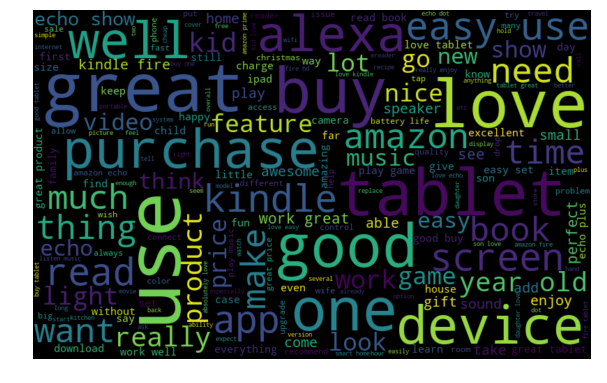

In [16]:
pos_words = ' '.join([text for text in processed_df['cleaned_text'][processed_df['sentiment'] == 1]])
pos_wordcloud = WordCloud(width=800, height=500, random_state=20, max_font_size=110).generate(pos_words)

plt.figure(figsize=(10,7))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

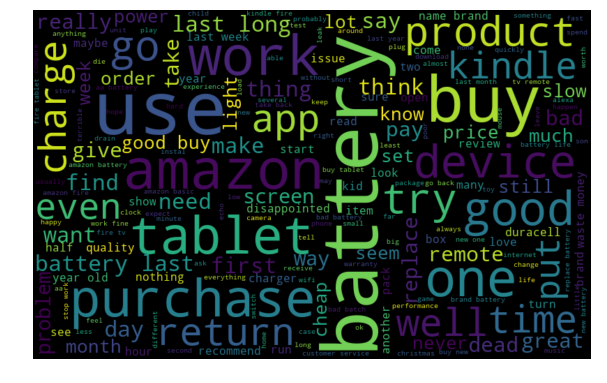

In [17]:
neg_words = ' '.join([text for text in processed_df['cleaned_text'][processed_df['sentiment'] == 0]])
neg_wordcloud = WordCloud(width=800, height=500, random_state=20, max_font_size=110).generate(neg_words)

plt.figure(figsize=(10,7))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

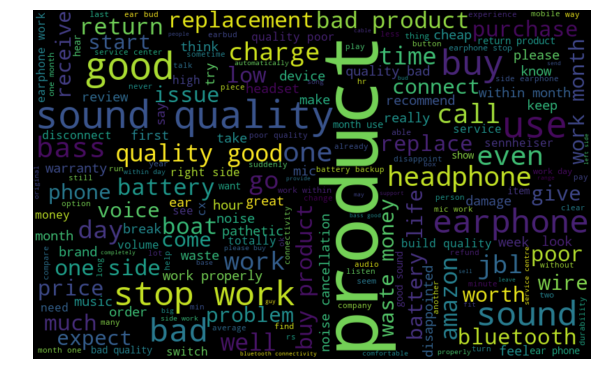

In [18]:
complaint_words = ' '.join([text for text in processed_df['cleaned_text'][processed_df['sentiment'] == 2]])
comp_wordcloud = WordCloud(width=800, height=500, random_state=20, max_font_size=110).generate(complaint_words)

plt.figure(figsize=(10,7))
plt.imshow(comp_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(processed_df['cleaned_text'], 
                                                    processed_df['sentiment'], 
                                                    test_size = 0.2,
                                                    random_state = 10)

In [20]:
print(X_train.shape)
print(X_test.shape)

(8502,)
(2126,)


In [21]:
tfidf = TfidfVectorizer(encoding='utf-8',
                       ngram_range=(1,2),
                       max_df=1.0,
                       min_df=10,
                       max_features=300,
                       norm='l2',
                       sublinear_tf=True)

In [22]:
train_features = tfidf.fit_transform(X_train).toarray()
print(train_features.shape)

(8502, 300)


In [23]:
test_features = tfidf.transform(X_test).toarray()
print(test_features.shape)

(2126, 300)


In [24]:
train_labels = Y_train
test_labels = Y_test

In [25]:
with open('pickles/amazon/processed_df.pickle', 'wb') as output:
    pickle.dump(processed_df, output)
    
with open('pickles/amazon/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
with open('pickles/amazon/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
with open('pickles/amazon/Y_train.pickle', 'wb') as output:
    pickle.dump(Y_train, output)
    
with open('pickles/amazon/Y_test.pickle', 'wb') as output:
    pickle.dump(Y_test, output)
    
with open('pickles/amazon/train_features.pickle', 'wb') as output:
    pickle.dump(train_features, output)
    
with open('pickles/amazon/test_features.pickle', 'wb') as output:
    pickle.dump(test_features, output)
    
with open('pickles/amazon/train_labels.pickle', 'wb') as output:
    pickle.dump(train_labels, output)
    
with open('pickles/amazon/test_labels.pickle', 'wb') as output:
    pickle.dump(test_labels, output)

with open('pickles/amazon/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)